In [ ]:
import pandas as pd

# Load your datasets
ev_sales = pd.read_csv('/content/EV_Dataset.csv')
ev_stations = pd.read_csv('/content/ev-charging-stations-india.csv')
simulated_data = pd.read_csv('/content/Simulated_City_EV_Data.csv')
final_data = pd.read_csv('/content/final_dataset.csv')  # optional


In [ ]:
# Check EV sales by state/year
print("EV Sales Dataset:")
ev_sales.head()

# Check existing EV stations
print("EV Stations Dataset:")
ev_stations.head()

# Check simulated city demographics and traffic
print("Simulated City Data:")
simulated_data.head()

# (Optional) Preview final_dataset
print("Final Dataset (if needed):")
final_data.head()


EV Sales Dataset:
EV Stations Dataset:
Simulated City Data:
Final Dataset (if needed):


,Unnamed: 0,State Name,Two Wheeler,Three Wheeler,Four Wheeler,Goods Vehicles,Public Service Vehicle,Special Category Vehicles,Ambulance/Hearses,Construction Equipment Vehicle,Other,Grand Total,total-charging-stations
0,0,Andaman and Nicobar Island,1,30.0,81,0.0,40.0,0.0,0.0,0.0,7.0,159,NaN
1,1,Arunachal Pradesh,14,0.0,5,0.0,0.0,0.0,0.0,0.0,1.0,20,NaN
2,2,Assam,721,47041.0,161,7.0,15.0,0.0,0.0,0.0,2.0,47947,10.0
3,3,Bihar,5003,59079.0,114,11.0,26.0,0.0,0.0,0.0,8.0,64241,9.0
4,4,Chandigarh,298,1410.0,182,0.0,40.0,0.0,0.0,0.0,1.0,1931,2.0


In [ ]:
print("Nulls in EV Sales:")
print(ev_sales.isnull().sum())

print("Nulls in EV Stations:")
print(ev_stations.isnull().sum())

print("Nulls in Simulated City Data:")
print(simulated_data.isnull().sum())

print("Nulls in Final Dataset:")
print(final_data.isnull().sum())


Nulls in EV Sales:
Year                 0
Month_Name           0
Date                 0
State                0
Vehicle_Class        0
Vehicle_Category     0
Vehicle_Type         0
EV_Sales_Quantity    0
dtype: int64
Nulls in EV Stations:
name          0
state         0
city          0
address      40
lattitude     6
longitude     6
type          8
dtype: int64
Nulls in Simulated City Data:
City                            0
Avg_Traffic_Congestion_Index    0
Avg_Household_Income_INR        0
Population                      0
EV_Adoption_Index               0
Existing_Charging_Stations      0
dtype: int64
Nulls in Final Dataset:
Unnamed: 0                        0
State Name                        0
Two Wheeler                       0
Three Wheeler                     0
Four Wheeler                      0
Goods Vehicles                    0
Public Service Vehicle            0
Special Category Vehicles         0
Ambulance/Hearses                 0
Construction Equipment Vehicle    0
Other 

In [ ]:
ev_stations.rename(columns={"lattitude": "latitude"}, inplace=True)


In [ ]:
# Handle missing values - Latitude/Longitude missing → Drop those rows, since location-based analysis needs coordinates.
ev_stations = ev_stations.dropna(subset=['latitude', 'longitude'])

In [ ]:
ev_stations['type'] = ev_stations['type'].fillna('Unknown')


In [ ]:
# Drop rows with null city or address in ev_stations
#ev_stations_cleaned = ev_stations.dropna(subset=['city', 'address'])


In [ ]:
ev_stations_backup = ev_stations.copy()


In [ ]:
# Group EV stations to count how many stations are present in each city
station_counts = ev_stations.groupby('city').size().reset_index(name='Charging_Station_Count')


In [ ]:
# Merge simulated city data with charging station counts on city name
merged_data = pd.merge(simulated_data, station_counts, how='left', left_on='City', right_on='city')

# Replace NaN values in Charging_Station_Count with 0 (i.e., cities with no known stations)
#merged_data['Charging_Station_Count'].fillna(0, inplace=True)
merged_data['Charging_Station_Count'] = merged_data['Charging_Station_Count'].fillna(0)



In [ ]:
# Drop extra 'city' column if it's redundant now
merged_data.drop(columns=['city'], inplace=True)


In [ ]:
merged_data.info()
merged_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   City                          10 non-null     object 
 1   Avg_Traffic_Congestion_Index  10 non-null     float64
 2   Avg_Household_Income_INR      10 non-null     int64  
 3   Population                    10 non-null     int64  
 4   EV_Adoption_Index             10 non-null     float64
 5   Existing_Charging_Stations    10 non-null     int64  
 6   Charging_Station_Count        10 non-null     int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 692.0+ bytes


,City,Avg_Traffic_Congestion_Index,Avg_Household_Income_INR,Population,EV_Adoption_Index,Existing_Charging_Stations,Charging_Station_Count
0,Mumbai,83.74,978726,14896698,0.79,12,44
1,Delhi,87.28,746273,10494758,0.38,30,72
2,Bengaluru,55.25,795247,16127962,0.50,54,9
3,Hyderabad,81.93,1314032,14572684,0.89,164,34
4,Chennai,67.59,931744,13679778,0.52,153,48


In [ ]:
from sklearn.preprocessing import StandardScaler

# Features for clustering
features = ['Avg_Traffic_Congestion_Index', 'Avg_Household_Income_INR', 'Population', 'EV_Adoption_Index', 'Charging_Station_Count']

X = merged_data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


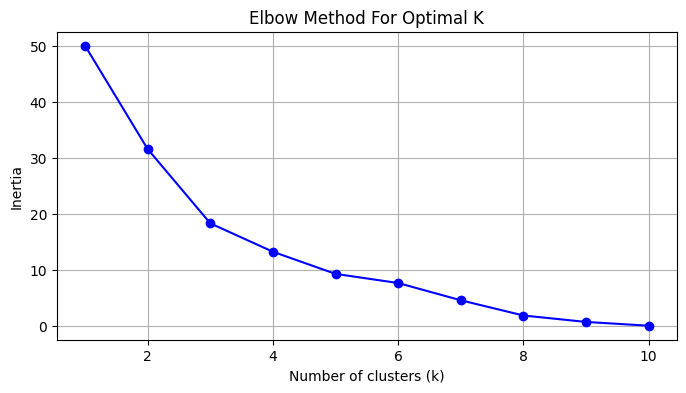

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try K values from 1 to 10
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


In [ ]:
# KMeans with K = 4
kmeans = KMeans(n_clusters=4, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
recommendation_map = {
    0: 'Add More EV Stations',
    1: 'Monitor Demand',
    2: 'Adequate Infrastructure',
    3: 'Emerging Market'
}

merged_data['EV_Station_Recommendation'] = merged_data['Cluster'].map(recommendation_map)


In [ ]:
# Save for Streamlit
merged_data.to_csv("merged_ev_data.csv", index=False)

# Save clustered data separately
merged_data.to_csv("EV_City_Clustered_Data.csv", index=False)

# Final view
merged_data[['City', 'Cluster', 'EV_Station_Recommendation']].head(10)


,City,Cluster,EV_Station_Recommendation
0,Mumbai,0,Add More EV Stations
1,Delhi,2,Adequate Infrastructure
2,Bengaluru,3,Emerging Market
3,Hyderabad,0,Add More EV Stations
4,Chennai,2,Adequate Infrastructure
5,Kolkata,3,Emerging Market
6,Pune,2,Adequate Infrastructure
7,Ahmedabad,0,Add More EV Stations
8,Jaipur,3,Emerging Market
9,Lucknow,1,Monitor Demand


In [ ]:
import pandas as pd

# Get cluster centers (scaled)
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
cluster_centers['Cluster'] = range(4)
cluster_centers


,Avg_Traffic_Congestion_Index,Avg_Household_Income_INR,Population,EV_Adoption_Index,Charging_Station_Count,Cluster
0,84.093333,1.209413e+06,1.625770e+07,0.743333,33.666667,0
1,71.270000,8.623970e+05,5.861925e+06,0.570000,7.000000,1
2,80.173333,8.270613e+05,1.008898e+07,0.416667,52.000000,2
3,55.646667,7.023513e+05,1.451206e+07,0.543333,16.000000,3


In [ ]:
# Sort cities by cluster
merged_data[['City', 'Cluster', 'Charging_Station_Count'] + features].sort_values('Cluster')


,City,Cluster,Charging_Station_Count,Avg_Traffic_Congestion_Index,Avg_Household_Income_INR,Population,EV_Adoption_Index,Charging_Station_Count
0,Mumbai,0,44,83.74,978726,14896698,0.79,44
3,Hyderabad,0,34,81.93,1314032,14572684,0.89,34
7,Ahmedabad,0,23,86.61,1335481,19303729,0.55,23
9,Lucknow,1,7,71.27,862397,5861925,0.57,7
6,Pune,2,36,85.65,803167,6092415,0.35,36
4,Chennai,2,48,67.59,931744,13679778,0.52,48
1,Delhi,2,72,87.28,746273,10494758,0.38,72
2,Bengaluru,3,9,55.25,795247,16127962,0.50,9
5,Kolkata,3,19,53.06,631229,14504222,0.67,19
8,Jaipur,3,20,58.63,680578,12903986,0.46,20


In [ ]:
# Save to Excel or CSV for reporting
merged_data.to_csv("EV_Station_Recommendations.csv", index=False)


In [ ]:
merged_data.to_csv("merged_ev_data.csv", index=False)


In [ ]:
print(merged_data.columns.tolist())


['City', 'Avg_Traffic_Congestion_Index', 'Avg_Household_Income_INR', 'Population', 'EV_Adoption_Index', 'Existing_Charging_Stations', 'Charging_Station_Count', 'Cluster', 'EV_Station_Recommendation']


In [ ]:
import sqlite3
import pandas as pd

# Step 1: Save the DataFrame to a SQLite database
conn = sqlite3.connect("ev_charging_data.db")
merged_data.to_sql("ev_city_data", conn, if_exists="replace", index=False)

# Step 2: Run SQL Queries

# Query 1: Top 5 Cities by EV Adoption Index
query1 = """
SELECT City, EV_Adoption_Index
FROM ev_city_data
ORDER BY EV_Adoption_Index DESC
LIMIT 5;
"""
top_ev_adoption = pd.read_sql_query(query1, conn)
print("Top 5 Cities by EV Adoption Index:")
print(top_ev_adoption)

# Query 2: Cities Needing More Charging Stations
query2 = """
SELECT City, EV_Station_Recommendation
FROM ev_city_data
WHERE EV_Station_Recommendation > 0
ORDER BY EV_Station_Recommendation DESC;
"""
stations_needed = pd.read_sql_query(query2, conn)
print("\nCities Needing More Charging Stations:")
print(stations_needed)

# Query 3: Average Income and Population
query3 = """
SELECT
    AVG(Avg_Household_Income_INR) AS Avg_Income,
    AVG(Population) AS Avg_Population
FROM ev_city_data;
"""
avg_stats = pd.read_sql_query(query3, conn)
print("\nAverage Income and Population:")
print(avg_stats)

# Optional: Close the connection
conn.close()


Top 5 Cities by EV Adoption Index:
        City  EV_Adoption_Index
0  Hyderabad               0.89
1     Mumbai               0.79
2    Kolkata               0.67
3    Lucknow               0.57
4  Ahmedabad               0.55

Cities Needing More Charging Stations:
        City EV_Station_Recommendation
0    Lucknow            Monitor Demand
1  Bengaluru           Emerging Market
2    Kolkata           Emerging Market
3     Jaipur           Emerging Market
4      Delhi   Adequate Infrastructure
5    Chennai   Adequate Infrastructure
6       Pune   Adequate Infrastructure
7     Mumbai      Add More EV Stations
8  Hyderabad      Add More EV Stations
9  Ahmedabad      Add More EV Stations

Average Income and Population:
   Avg_Income  Avg_Population
0    907887.4      12843815.7


In [ ]:
merged_data.to_csv("EV_City_Clustered_Data.csv", index=False)
